In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from numpy import linalg
from scipy.linalg import expm
from scipy.optimize import fsolve
from scipy.special import comb
from tqdm import tqdm
import itertools

#sympy imports
import sympy as sp
from sympy import Matrix, symbols, sqrt
from sympy.physics.control.lti import TransferFunction
from sympy.parsing.mathematica import parse_mathematica
from sympy import var

#define constants
e = 1.602*10**(-19)#C
hbar = 1.054*10**(-34)#Js
h = hbar*2*np.pi
phi0 = hbar/2/e
np.set_printoptions(precision=7,suppress=True)


# Set values of parameters and get the relevant matrices from Mathematica

In [2]:
#initialize sympy variables
Lj, wj, zr, wr, Cj, Cjr, Cr, Lr, Crs, Cc, Cg, R, phi,s = symbols('Lj wj zr wr Cj Cjr Cr Lr Crs Cc Cg R phi s')
# Define a function that sets small coefficients to zero
precision = 1e-13
def set_small_coeffs_to_zero(expr):
    return expr.xreplace({n: 0 for n in expr.atoms(sp.Number) if abs(n) < precision})

# Assign parameter values.
zr_value = 50 #Ohm
wr_value = 2*np.pi*7 #GHz
Cr_value = 1/(wr_value*zr_value) #nf
Lr_value = zr_value/(wr_value) #nH
Cj_value = 150*10**(-6) #nF
Crs_value = 100*10**(-6) #nF
Cjr_value = 10*10**(-6) #nF
Cg_value = 25*10**(-6) #nF 
R_value = 50 #Ohm 
phi_value = np.pi/3

values = [zr_value, wr_value, Cr_value, Lr_value, Cj_value, Crs_value, Cjr_value, Cg_value, R_value, phi_value]
print(values)
print(wr_value/2/np.pi)
# Convert the list to a numpy array
values_array = np.array(values,dtype=np.float64)

# Save the array to a text file
np.savetxt("Mathematica-files/values.txt", values_array)
#now run the Mathematica file, then run all. 

[50, 43.982297150257104, 0.00045472840883398674, 1.1368210220849668, 0.00015, 9.999999999999999e-05, 9.999999999999999e-06, 2.4999999999999998e-05, 50, 1.0471975511965976]
7.0


In [3]:
with open("Mathematica-files/wjchiral.txt",'r') as file:# Mathematica gives us the frequency of wj that gives chiral dynamics
    wjstring = file.read()

wj_value = parse_mathematica(wjstring)
wj_value = np.float64(wj_value)
s_value = 1j*wj_value
w_value = wj_value
print(wj_value)

27.267721043003593


# Now run all

## Loading the series matrix decomposition of Z

In [4]:
#now we read the output matrices from Mathematica
strings = ["A0","A1","A2","A3","A4","B1","B2","B3","B4","poles"]

list_strings = []
for string in strings:
    with open("Mathematica-files/"+string+".txt",'r') as file:
        list_strings.append(file.read())

dict_strings = dict(zip(strings,list_strings))

A0 = parse_mathematica(dict_strings["A0"])
A1 = parse_mathematica(dict_strings["A1"])
A2 = parse_mathematica(dict_strings["A2"])
A3 = parse_mathematica(dict_strings["A3"])
A4 = parse_mathematica(dict_strings["A4"])
B1 = parse_mathematica(dict_strings["B1"])
B2 = parse_mathematica(dict_strings["B2"])
B3 = parse_mathematica(dict_strings["B3"])
B4 = parse_mathematica(dict_strings["B4"])
poles = parse_mathematica(dict_strings["poles"])
print(poles)

A0 = Matrix(A0)
A1 = Matrix(A1)
A2 = Matrix(A2)
A3 = Matrix(A3)
A4 = Matrix(A4)
B1 = Matrix(B1)
B2 = Matrix(B2)
B3 = Matrix(B3)
B4 = Matrix(B4)
poles = Matrix(poles)
w1, w2, w3, w4 = -1j*poles[1], -1j*poles[2], -1j*poles[3], -1j*poles[4]
omegas = [w1,w2,w3,w4]

(0.0, 37.68986491681974*I, 40.368972790971895*I, 42.62701105832492*I, 110.32065684833859*I)


## We use the above to define Z, ZacR, ZacNR, Zdc as sympy matrices

In [5]:
#we use those to define the impedance matrix in its Cauer form
Z = A0/s + (A1*s+B1)/(s**2+w1**2)+(A2*s+B2)/(s**2+w2**2)+(A3*s+B3)/(s**2+w3**2)+(A4*s+B4)/(s**2+w4**2)
print(Z.evalf(10))

ZacR = (A1*s)/(s**2+w1**2)+(A2*s)/(s**2+w2**2)+(A3*s)/(s**2+w3**2)+(A4*s)/(s**2+w4**2)
ZacNR = B1/(s**2+w1**2)+B2/(s**2+w2**2)+B3/(s**2+w3**2)+B4/(s**2+w4**2)
Zdc = A0/s

Matrix([[0.9730103149*s/(s**2 + 12170.64733) + 2.689680158*s/(s**2 + 1817.062072) + 2.450705421*s/(s**2 + 1629.653964) + 1.955644581*s/(s**2 + 1420.525917) + 6250.0/s, 2.689680158*s/(s**2 + 1817.062072) + (85.67802402 - 1.225352711*s)/(s**2 + 1629.653964) + (-0.9778222903*s - 63.8329832)/(s**2 + 1420.525917) + (-0.4865051575*s - 92.96188362)/(s**2 + 12170.64733), 2.689680158*s/(s**2 + 1817.062072) + (63.8329832 - 0.9778222903*s)/(s**2 + 1420.525917) + (92.96188362 - 0.4865051575*s)/(s**2 + 12170.64733) + (-1.225352711*s - 85.67802402)/(s**2 + 1629.653964)], [2.689680158*s/(s**2 + 1817.062072) + (63.8329832 - 0.9778222903*s)/(s**2 + 1420.525917) + (92.96188362 - 0.4865051575*s)/(s**2 + 12170.64733) + (-1.225352711*s - 85.67802402)/(s**2 + 1629.653964), 0.9730103149*s/(s**2 + 12170.64733) + 2.689680158*s/(s**2 + 1817.062072) + 2.450705421*s/(s**2 + 1629.653964) + 1.955644581*s/(s**2 + 1420.525917) + 6250.0/s, 2.689680158*s/(s**2 + 1817.062072) + (85.67802402 - 1.225352711*s)/(s**2 + 1629

## Transform the above to numpy and obtain the transformer ratios

In [6]:
A0 = np.array(A0,dtype=np.float64)
A1 = np.array(A1,dtype=np.float64)
A2 = np.array(A2,dtype=np.float64)
A3 = np.array(A3,dtype=np.float64)
A4 = np.array(A4,dtype=np.float64)
B1 = np.array(B1,dtype=np.float64)
B2 = np.array(B2,dtype=np.float64)
B3 = np.array(B3,dtype=np.float64)
B4 = np.array(B4,dtype=np.float64)
poles = np.array(poles,dtype=np.complex128)
#one of the B's is going to be zero, let's make that B1. 
B_mat = [B1,B2,B3,B4]
A_mat = [A1,A2,A3,A4]
for i in range(4):
    if np.all(np.allclose(B_mat[i],np.zeros(3))):
        B1_new = B_mat[i]
        A1_new = A_mat[i]
        wr = omegas[i]
        B_mat.pop(i)
        A_mat.pop(i)
        omegas.pop(i)
        print('wr',wr,i)
        break

omegas = [wr]+omegas
B2_new, B3_new, B4_new = B_mat[0], B_mat[1], B_mat[2]
A2_new, A3_new, A4_new = A_mat[0], A_mat[1], A_mat[2]
B1 = B1_new
A1 = A1_new
B2, B3, B4 = B2_new, B3_new, B4_new
A2, A3, A4 = A2_new, A3_new, A4_new
w1,w2,w3,w4 = omegas[0], omegas[1], omegas[2], omegas[3]
print(A1,B1)
print(omegas)


wr 42.62701105832492 2
[[2.6896802 2.6896802 2.6896802]
 [2.6896802 2.6896802 2.6896802]
 [2.6896802 2.6896802 2.6896802]] [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[42.62701105832492, 37.68986491681974, 40.368972790971895, 110.32065684833859]


In [7]:
def get_transformer_ratios_NR(A,B,w):
    #we calculate the transformer ratios
    #A,B have to be numpy arrays
    eigenvalues, eigenvectors = np.linalg.eig(A)
    Aeigenvalues = eigenvalues[np.abs(eigenvalues) > precision]
    Aeigenvectors = eigenvectors[:, np.abs(eigenvalues) > precision]
    
    #now we make them orthogonal
    lambda1 = Aeigenvectors[:, 0] - np.dot(Aeigenvectors[:, 0], Aeigenvectors[:, 1]) * Aeigenvectors[:, 1]
    lambda1norm = np.linalg.norm(lambda1)
    lambda1 = lambda1 / lambda1norm
    lambda2 = Aeigenvectors[:, 1]
    
    n1 = np.sqrt(Aeigenvalues[0])*lambda1
    n2 = np.sqrt(Aeigenvalues[1])*lambda2
    Anlnr = np.outer(n1, n1) + np.outer(n2, n2)
    Bnlnr = np.array(w * (np.outer(n1, n2) - np.outer(n2, n1)),dtype=np.float64)#n1 is right and n2 left if the sign is positive.
    test_A = np.allclose(Anlnr, A)
    test_B = np.allclose(Bnlnr, B)

    if test_B:
        return (n2,n1), (test_A,test_B) #nl, nr
    elif np.allclose(-Bnlnr, B):
        test_B = np.allclose(-Bnlnr, B)
        return (n1,n2),(test_A,test_B) #nl, nr
    else:
        print("Error")
        return (n1,n2),(test_A,test_B)
    
def get_transformer_ratios_R(A):
    #we calculate the transformer ratios
    #A has to be numpy array
    eigenvalues, eigenvectors = np.linalg.eig(A)
    Aeigenvalues = eigenvalues[np.abs(eigenvalues) > precision]
    Aeigenvectors = eigenvectors[:, np.abs(eigenvalues) > precision]
    
    r = Aeigenvectors[:, 0]*np.sqrt(Aeigenvalues[0])
    Ar = np.outer(r, r)
    test_A = np.allclose(Ar, A)
    return r, test_A

r1, test1 = get_transformer_ratios_R(A1)

nlnr2, test2 = get_transformer_ratios_NR(A2,B2,w2)
nlnr3, test3 = get_transformer_ratios_NR(A3,B3,w3)
nlnr4, test4 = get_transformer_ratios_NR(A4,B4,w4)
print(test1,test2,test3,test4)

True (True, True) (True, True) (True, True)


### Construct the transformer matrices using the ratios obtained above

In [8]:
R = np.array([r1])
N2 = np.array([nlnr2[0],nlnr2[1]])
N3 = np.array([nlnr3[0],nlnr3[1]])
N4 = np.array([nlnr4[0],nlnr4[1]])
NL = np.array([nlnr2[0],nlnr3[0],nlnr4[0]])
NR = np.array([nlnr2[1],nlnr3[1],nlnr4[1]])
N = np.block([[N2],[N3],[N4]])
print(N.shape, R.shape)
T = np.block([[R],[N]])
print(T.shape)

(6, 3) (1, 3)
(7, 3)


### Check is ok

In [9]:
A1 = np.dot(R.T,R)
A2 = np.outer(NL[0],NL[0])+np.outer(NR[0],NR[0])
A3 = np.outer(NL[1],NL[1])+np.outer(NR[1],NR[1])
A4 = np.outer(NL[2],NL[2])+np.outer(NR[2],NR[2])

B2 = w2*(np.outer(NR[0],NL[0]) - np.outer(NL[0],NR[0]))
B3 = w3*(np.outer(NR[1],NL[1]) - np.outer(NL[1],NR[1]))
B4 = w4*(np.outer(NR[2],NL[2]) - np.outer(NL[2],NR[2]))

ZacRnum = Matrix((A1*s)/(s**2+w1**2)+(A2*s)/(s**2+w2**2)+(A3*s)/(s**2+w3**2)+(A4*s)/(s**2+w4**2))
ZacNRnum = Matrix(B1/(s**2+w1**2)+B2/(s**2+w2**2)+B3/(s**2+w3**2)+B4/(s**2+w4**2))
Zdcnum = Matrix(A0/s)
Zs = Matrix(ZacRnum + ZacNRnum + Zdcnum)
Znum = np.array(Zs.subs({s:1j*wj_value}),dtype=np.complex128)
Zmat_0 = np.array(Z.subs({s:1j*wj_value}),dtype=np.complex128)
test5 = np.allclose(Znum,Zmat_0)
print(np.allclose(Znum,Zmat_0))
# print(R,'\n',N)

True


## Transformer ratios tests. Should all be True. 

In [10]:
#we put all tests together to be sure
tests = [test1,test2[0],test2[1],test3[0],test3[1],test4[0],test4[1],test5]
all_tests = all(tests)
print(all_tests)

True


## Obtaining Lj to use in the linear sector definition

In [11]:
# from Eq(6) in the paper, and appendix C. 
CJI = A0
CJmat = np.linalg.inv(CJI)
Cj_value = CJmat[0,0]
Ec = e**2/2/Cj_value/hbar

def get_Lj_value(Lj):# we solve Eq(6) for Lj
    wj = 1/np.sqrt(Lj*Cj_value)
    return wj*(1-Ec/wj/(1-Ec/wj))-wj_value

Lj_value = fsolve(get_Lj_value, 9)[0]
wj0 = 1/np.sqrt(Lj_value*Cj_value)
zj_value = np.sqrt(Lj_value/Cj_value)
#check Ej/Ec
Ej = phi0**2/Lj_value/hbar
print('Ec/h (GHz):',Ec/2/np.pi)
print('EJ/h (GHz):',Ej/2/np.pi)#GHz
print('Ej/Ec:',Ej/Ec)
print('wj0/wj:',wj0/wj_value)
print('zj:',zj_value)

Ec/h (GHz): 0.12110290635994209
EJ/h (GHz): 20.571065897845546
Ej/Ec: 169.86434525942934
wj0/wj: 1.0286833254445371
zj: 222.8175911441535


## Build the exact linear Hamiltonian

In [12]:
#we use the results in appendix D.
# Get CJ
CJ = np.linalg.inv(CJI)
wr = np.float64(w1)#reciprocal pole
OmegaNR = np.array(np.diag(omegas[1:]),dtype=np.float64)

#now the HJ, HI, K
zero3 = np.zeros((3,3)) 
zero13 = np.zeros((1,3))
zero23 = np.zeros((2,3))
zero16 = np.zeros((1,6))
zero36 = np.zeros((3,6))
zero6 = np.zeros((6,6))
zero26 = np.zeros((2,6))
I6 = np.eye(6)
I3 = np.eye(3)
HJ = np.block([[zero3,zero3],[zero3, CJI+np.dot(T.T,T)]])#we will later add the nonlinear potential in the photon basis
HI = np.block([[w1,0,zero16],[0,w1,zero16],[zero23.T,OmegaNR,zero3],[zero23.T,zero3,OmegaNR]])
K = np.block([[zero13.T,zero13.T,zero3,zero3],[zero13.T,R.T*np.sqrt(wr),np.dot(NR.T,np.sqrt(OmegaNR)),np.dot(NL.T,np.sqrt(OmegaNR))]])
H = np.block([[HJ,K],[K.T,HI]])
JJ = np.block([[zero3,I3],[-I3,zero3]])
JR = np.array([[0,1],[-1,0]])
JNR = np.block([[zero3,I3],[-I3,zero3]])
J = np.block([[JJ,zero26.T,zero6],[zero26,JR,zero26],[zero6,zero26.T,JNR]])
H = np.array(H,dtype=np.float64)

In [13]:
#we rescale with the junctions impedance to have H in dimensions GHz, and rearrange the inner modes structure
LJ = np.diag([Lj_value,Lj_value,Lj_value])
LJI = np.linalg.inv(LJ)
CJdiag = np.diag([CJ[0,0],CJ[1,1],CJ[2,2]])
CJdiagI = np.linalg.inv(CJdiag)
ZJ = np.diag([zj_value,zj_value,zj_value])
ZJI = np.linalg.inv(ZJ)
Omega_J = np.sqrt(np.dot(LJI,CJdiagI))
TZ = np.dot(T,np.sqrt(ZJI))
HJ = np.block([[zero3,zero3],[zero3, Omega_J+np.dot(TZ.T,TZ)]])
HI = np.diag([wr,w2,w3,w4,wr,w2,w3,w4])
RZ = np.dot(R,np.sqrt(ZJI))
NLZ = np.dot(NL,np.sqrt(ZJI))
NRZ = np.dot(NR,np.sqrt(ZJI))
K = np.block([[zero13.T,zero13.T,zero3,zero3],[zero13.T,RZ.T*np.sqrt(wr),np.dot(NRZ.T,np.sqrt(OmegaNR)),np.dot(NLZ.T,np.sqrt(OmegaNR))]])

H = np.array(np.block([[HJ,K],[K.T,HI]]),dtype=np.float64)
zero68 = np.zeros((6,8))
zero4 = np.zeros((4,4))
I4 = np.eye(4) 
JI = np.block([[zero4,I4],[-I4,zero4]])
J = np.block([[JJ,zero68],[zero68.T,JI]])
print('HJ:','\n',HJ)
print('HI:','\n',HI)
print('K:','\n',K[3:6,:])

HJ: 
 [[ 0.         0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.        28.0860636 -0.        -0.       ]
 [ 0.         0.         0.        -0.        28.0860636 -0.       ]
 [ 0.         0.         0.        -0.        -0.        28.0860636]]
HI: 
 [[42.62701105832492 0 0 0 0 0 0 0]
 [0 37.68986491681974 0 0 0 0 0 0]
 [0 0 40.368972790971895 0 0 0 0 0]
 [0 0 0 110.32065684833859 0 0 0 0]
 [0 0 0 0 42.62701105832492 0 0 0]
 [0 0 0 0 0 37.68986491681974 0 0]
 [0 0 0 0 0 0 40.368972790971895 0]
 [0 0 0 0 0 0 0 110.32065684833859]]
K: 
 [[ 0.         0.7173284  0.5746045 -0.0278167  0.661686   0.0250868
   0.6657573  0.2095831]
 [ 0.         0.7173284 -0.2655764 -0.5626544 -0.1493387 -0.5101655
  -0.3569686 -0.6778284]
 [ 0.         0.7173284 -0.309028   0.590471  -0.5123473  0.4850787
  -0.3087887  0.4682453]]


In [14]:
# Finally we rearrange in flux vs charge sectors
#first we reshape the Hamiltonian to flux-charge separation
Omega_JQ = Omega_J+np.dot(TZ.T,TZ)
Kjr = RZ.T*np.sqrt(wr)
Kjnr_qphi = np.dot(NRZ.T,np.sqrt(OmegaNR))
Kjnr_qq = np.dot(NLZ.T,np.sqrt(OmegaNR))
H = np.block([[zero3,zero13.T,zero3,zero3,zero13.T,zero3],
              [zero13,wr,zero13,zero13,0,zero13],
              [zero3,zero13.T,OmegaNR,Kjnr_qphi.T,zero13.T,zero3],
              [zero3,zero13.T,Kjnr_qphi,Omega_JQ,Kjr,Kjnr_qq],
              [zero13,0,zero13,Kjr.T,wr,zero13],
              [zero3,zero13.T,zero3,Kjnr_qq.T,zero13.T,OmegaNR]])

H = H
#we also have to reshape J
zero7 = np.zeros((7,7))
I7 = np.eye(7)
J = np.block([[zero7,I7],[-I7,zero7]])
print(H)

[[  0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.
    0.          0.       ]
 [  0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.
    0.          0.       ]
 [  0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.
    0.          0.       ]
 [  0.          0.          0.         42.6270111   0.          0.
    0.          0.          0.          0.          0.          0.
    0.          0.       ]
 [  0.          0.          0.          0.         37.6898649   0.
    0.          0.5746045  -0.2655764  -0.309028    0.          0.
    0.          0.       ]
 [  0.          0.          0.          0.          0.         40.3689728
    0.         -0.0278167  -0.5626544   0.590471    0.          0.
    0.          0.       ]
 [  0.          0.         

## Construct the exact quantum Hamiltonian in the N-photon subspace

### Construct the anhilation and creation operators

In [15]:
# A simple way will be using dictionaries to store the states and construct the operators
def state_dict(number_of_excitations_on_each_site):
    state = {}
    for i in range(len(number_of_excitations_on_each_site)):
        state[str(i)] = number_of_excitations_on_each_site[i]
    return state

# Binary representation of balls (the photons, represented by a 0) and cells (represented by 1) for the states
def state_from_binary(binary):
    state = state_dict([0]*7)
    counter_position = 0
    counter_photon = 0
    for i in range(len(binary)):
        digit_i = binary[i]
        if digit_i ==1:
            state[str(counter_position)] = counter_photon
            counter_position+=1
            counter_photon = 0
        else:
            counter_photon+=1
    state[str(counter_position)] = counter_photon
    return state

binary = [1,1,0,1,1,1,1,0,0]
print(state_from_binary(binary))

{'0': 0, '1': 0, '2': 1, '3': 0, '4': 0, '5': 0, '6': 2}


In [16]:
# now simply doing the combinations of how many zeros in binary of n+m-1 digits we can get all states
binary_7 = [1]*7
binary_8 = [1]*8
binary_9 = [1]*9
binary_10 = [1]*10 
binary_11 = [1]*11 

comb_1_photon = list(itertools.combinations(range(7), 1))
comb_2_photon = list(itertools.combinations(range(8), 2))
comb_3_photon = list(itertools.combinations(range(9), 3))
comb_4_photon = list(itertools.combinations(range(10), 4))
comb_5_photon = list(itertools.combinations(range(11), 5))

all_states = [state_dict([0]*7)]
for i in comb_1_photon:
    binary = binary_7.copy()
    binary[i[0]] = 0
    state = state_from_binary(binary)
    all_states.append(state)

for i,j in comb_2_photon:
    binary = binary_8.copy()
    binary[i] = 0
    binary[j] = 0
    state = state_from_binary(binary)
    all_states.append(state)

for i,j,k in comb_3_photon:
    binary = binary_9.copy()
    binary[i] = 0
    binary[j] = 0
    binary[k] = 0
    state = state_from_binary(binary)
    all_states.append(state)

for i,j,k,l in comb_4_photon:
    binary = binary_10.copy()
    binary[i] = 0
    binary[j] = 0
    binary[k] = 0
    binary[l] = 0
    state = state_from_binary(binary)
    all_states.append(state)

# # one can go to the 5 photon subspace to check convergence
# for i,j,k,l,m in comb_5_photon:
#     binary = binary_11.copy()
#     binary[i] = 0
#     binary[j] = 0
#     binary[k] = 0
#     binary[l] = 0
#     binary[m] = 0
#     state = state_from_binary(binary)
#     all_states.append(state)

print(len(all_states))
total_space = len(all_states)

330


In [17]:
# Define lower and increasing operations to construct a_i for all i from 0 to 6. 

def lower_operation(state_entry, i):
    state = state_entry.copy()
    if state[str(i)] == 0:
        return 0
    else:
        state[str(i)] = state[str(i)]-1
        return state

def increase_operation(state_entry,i):
    state = state_entry.copy()
    state[str(i)] = state[str(i)]+1
    return state

def is_state_zero(state):
    if state==0:
        return True
    return False

def check_two_states_equal(state_j,state_k):
    if is_state_zero(state_j):
        return False
    elif is_state_zero(state_k):
        return False
    else:
        for i in range(len(state_j.keys())):
            if state_j[str(i)] != state_k[str(i)]:
                return False
    return True

all_a = []
for i in range(7):
    a_i = 0*np.eye(total_space)
    for j in range(total_space): #we will get the matrix elements <j|a_i|k>, so a_i acts on |k>
        for k in range(total_space):
            state_j = all_states[j].copy()
            state_k = all_states[k].copy()
            occupation_i_k = state_k[str(i)]
            a_i_over_k = lower_operation(state_k,i)
            if a_i_over_k == 0:
                a_i[j,k] = 0
            else:
                if check_two_states_equal(a_i_over_k,state_j):
                    a_i[j,k] = np.sqrt(occupation_i_k)
                else:
                    a_i[j,k] = 0

    non_zero_indices = np.nonzero(a_i)
    all_a.append(a_i)

all_a_dag = []
for i in range(7):
    a_i = 0*np.eye(total_space)
    for j in range(total_space): #we will get the matrix elements <j|adag_i|k>, so adag_i acts on |k>
        for k in range(total_space):
            state_j = all_states[j].copy()
            state_k = all_states[k].copy()
            occupation_i_k = state_k[str(i)]
            a_i_over_k = increase_operation(state_k,i)
            if check_two_states_equal(a_i_over_k,state_j):
                a_i[j,k] = np.sqrt(occupation_i_k+1)
            else:
                a_i[j,k] = 0

    non_zero_indices = np.nonzero(a_i)
    all_a_dag.append(a_i)

total_N = sum([np.dot(a_dag,a) for a_dag,a in zip(all_a_dag,all_a)])#this is the total number operator, can be used to check all is good.
print(total_N)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 4. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 4.]]


In [18]:
phi_ops, q_ops = [], []
for i in range(7):
    phi_ops.append(((all_a_dag[i]+all_a[i])/np.sqrt(2)).copy())
    q_ops.append((1j*(all_a_dag[i]-all_a[i])/np.sqrt(2)).copy())


### Now construct the N-photon subspace exact Hamiltonian

In [19]:
#now we can construct the Hamiltonian in the 0, 1, 2, 3 photon subspace
c = np.sqrt(zj_value)*np.sqrt(hbar)/phi0 # the rescaling constant for the flux inside the cosine



print('Ej',Ej,'Ejc^2',Ej*c**2,'1/sqrt(LjCj)',1/np.sqrt(Lj_value*Cj_value),'Ejc^4/24',Ej*c**4/24,'Ec/3',Ec/3)

Hexact_l = 0*np.eye(total_space,dtype=np.complex128)
Hexact_nl = 0*np.eye(total_space,dtype=np.complex128)

from scipy.linalg import expm

for i in range(7):
    phi_i = phi_ops[i].copy()
    q_i = q_ops[i].copy()
    if i<3:
        cos_i = -c**2*np.dot(phi_i,phi_i)/2+c**4*np.dot(np.dot(phi_i,phi_i),np.dot(phi_i,phi_i))/24 #higher orders can be added but won't change the results in the low photon regime.
        Hexact_nl+= -Ej*cos_i
    
    for j in range(7):
        phi_j = phi_ops[j].copy()
        q_j = q_ops[j].copy()
        Hexact_l+= H[i,j]*np.dot(phi_i,phi_j)+H[i+7,j+7]*np.dot(q_i,q_j)+H[i+7,j]*np.dot(q_i,phi_j)+H[i,j+7]*np.dot(phi_i,q_j)

Hexact = qt.Qobj(Hexact_l/2+Hexact_nl)

Ej 129.25181900236618 Ejc^2 28.04984995981092 1/sqrt(LjCj) 28.04984995981092 Ejc^4/24 0.2536373339658444 Ec/3 0.2536373339658445


### Construct the operators

In [20]:
def state_from_binary(binary):
    state = state_dict([0]*3)#changed from 7 to 3
    counter_position = 0
    counter_photon = 0
    for i in range(len(binary)):
        digit_i = binary[i]
        if digit_i ==1:
            state[str(counter_position)] = counter_photon
            counter_position+=1
            counter_photon = 0
        else:
            counter_photon+=1
    state[str(counter_position)] = counter_photon
    return state

# now simply doing the combinations of how many zeros in binary of n+m-1 digits we can get all states
binary_3 = [1]*3
binary_4 = [1]*4
binary_5 = [1]*5
binary_6 = [1]*6 
binary_7 = [1]*7 

comb_1_photon = list(itertools.combinations(range(3), 1))
comb_2_photon = list(itertools.combinations(range(4), 2))
comb_3_photon = list(itertools.combinations(range(5), 3))
comb_4_photon = list(itertools.combinations(range(6), 4))
comb_5_photon = list(itertools.combinations(range(7), 5))

all_states_eff = [state_dict([0]*3)]
for i in comb_1_photon:
    binary = binary_3.copy()
    binary[i[0]] = 0
    state = state_from_binary(binary)
    all_states_eff.append(state)

for i,j in comb_2_photon:
    binary = binary_4.copy()
    binary[i] = 0
    binary[j] = 0
    state = state_from_binary(binary)
    all_states_eff.append(state)

for i,j,k in comb_3_photon:
    binary = binary_5.copy()
    binary[i] = 0
    binary[j] = 0
    binary[k] = 0
    state = state_from_binary(binary)
    all_states_eff.append(state)

for i,j,k,l in comb_4_photon:
    binary = binary_6.copy()
    binary[i] = 0
    binary[j] = 0
    binary[k] = 0
    binary[l] = 0
    state = state_from_binary(binary)
    all_states_eff.append(state)

# one can go to the 5 photon subspace to check convergence
for i,j,k,l,m in comb_5_photon:
    binary = binary_7.copy()
    binary[i] = 0
    binary[j] = 0
    binary[k] = 0
    binary[l] = 0
    binary[m] = 0
    state = state_from_binary(binary)
    all_states_eff.append(state)

print(len(all_states_eff))
total_space_eff = len(all_states_eff)

56


In [21]:
all_a_eff = []
for i in range(3):#changed 7 to 3
    a_i = 0*np.eye(total_space_eff)
    for j in range(total_space_eff): #we will get the matrix elements <j|a_i|k>, so a_i acts on |k>
        for k in range(total_space_eff):
            state_j = all_states[j].copy()
            state_k = all_states[k].copy()
            occupation_i_k = state_k[str(i)]
            a_i_over_k = lower_operation(state_k,i)
            if a_i_over_k == 0:
                a_i[j,k] = 0
            else:
                if check_two_states_equal(a_i_over_k,state_j):
                    a_i[j,k] = np.sqrt(occupation_i_k)
                else:
                    a_i[j,k] = 0

    non_zero_indices = np.nonzero(a_i)
    all_a_eff.append(a_i)

all_a_dag_eff = []
for i in range(3):
    a_i = 0*np.eye(total_space_eff)
    for j in range(total_space_eff): #we will get the matrix elements <j|adag_i|k>, so adag_i acts on |k>
        for k in range(total_space_eff):
            state_j = all_states[j].copy()
            state_k = all_states[k].copy()
            occupation_i_k = state_k[str(i)]
            a_i_over_k = increase_operation(state_k,i)
            if check_two_states_equal(a_i_over_k,state_j):
                a_i[j,k] = np.sqrt(occupation_i_k+1)
            else:
                a_i[j,k] = 0

    non_zero_indices = np.nonzero(a_i)
    all_a_dag_eff.append(a_i)

total_N_eff = sum([np.dot(a_dag,a) for a_dag,a in zip(all_a_dag_eff,all_a_eff)])#this is the total number operator, can be used to check all is good.

### Now the effective Hamiltonian

In [22]:
#define the Z matrices at frequency wj_value
Zwj = np.array(Zs.subs(s,1j*wj_value),dtype=np.complex128)
ZacRwj = np.array(ZacRnum.subs(s,1j*wj_value),dtype=np.complex128)
ZacNRwj = np.array(ZacNRnum.subs(s,1j*wj_value),dtype=np.complex128)
Zdcwj = np.array(Zdcnum.subs(s,1j*wj_value),dtype=np.complex128)

#rescale it following Eqs C58
Zwj = np.dot(np.dot(np.sqrt(CJdiag),Zwj),np.sqrt(CJdiag))
ZacR_wj = np.dot(np.dot(np.sqrt(CJdiag),ZacRwj),np.sqrt(CJdiag))
ZacNR_wj = np.dot(np.dot(np.sqrt(CJdiag),ZacNRwj),np.sqrt(CJdiag))
Zdc_wj = np.dot(np.dot(np.sqrt(CJdiag),Zdcwj),np.sqrt(CJdiag))

def J_ij_paper(i,j):#Eq 8 simplified by the symmetry
    return (1j/2)*wj_value**2*Zwj[i,j]

delta_i = -Ec*(wj0/wj_value)**2#anharmonicity defined above Eq 7
wi = wj_value+J_ij_paper(0,0)#Eq 5

Heff = 0*np.eye(total_space_eff,dtype=np.complex128)
for i in range(3):
    adagi = all_a_dag_eff[i].copy()
    ai = all_a_eff[i].copy()
    phi_i = (adagi+ai).copy()/np.sqrt(2)
    ni = np.dot(adagi,ai)
    Heff+= (wi-delta_i/2)*ni+(delta_i/2)*np.dot(ni,ni)

for i in range(3):
    for j in range(3):
        if i!=j:
            adagi,ai = all_a_dag_eff[i].copy(),all_a_eff[i].copy()
            adagj,aj = all_a_dag_eff[j].copy(),all_a_eff[j].copy()
            Heff+= J_ij_paper(i,j)*np.dot(ai,adagj)

Heff = qt.Qobj(Heff)

## Run the exact dynamics

In [23]:
#get the T final 
Jcoupling = J_ij_paper(0,1)
Jabs = np.abs(Jcoupling)*10**3#MHz
tfinal = 2*np.pi/(Jabs)/np.sqrt(3)#\mu s
tlist = np.arange(0, tfinal, .001)
print(tfinal, Jabs,'phase',np.angle(Jcoupling)*6/np.pi)

#propagators
Uexact = (-1j*Hexact*tlist[1]*10**3).expm()
Ueff = (-1j*Heff*tlist[1]*10**3).expm()
#number operators
n_list = [np.dot(adag,a) for adag,a in zip(all_a_dag,all_a)]
neff_list = [np.dot(adag,a) for adag,a in zip(all_a_dag_eff,all_a_eff)]
n_list = [qt.Qobj(n) for n in n_list]
neff_list = [qt.Qobj(n) for n in neff_list]

#initial states
psi0 = qt.basis(total_space,1)
psi0eff = qt.basis(total_space_eff,1)
psit = psi0.copy()
psiteff = psi0eff.copy()

5.316827602625748 0.6822863180060462 phase -1.0000000000378384


In [24]:
expect_vals, expect_vals_eff = [], []
for t in tqdm(tlist):
    exp_t, exp_t_eff = [], []
    for i in range(3):
        exp_t.append(qt.expect(n_list[i],psit))
        exp_t_eff.append(qt.expect(neff_list[i],psiteff))
    psit = Uexact*psit
    psiteff = Ueff*psiteff
    expect_vals.append(exp_t)
    expect_vals_eff.append(exp_t_eff)

expect_vals = np.array(expect_vals)
expect_vals_eff = np.array(expect_vals_eff)


100%|██████████| 5317/5317 [00:03<00:00, 1561.58it/s]


# Plotting

Ej/Ec 169.86434525942934


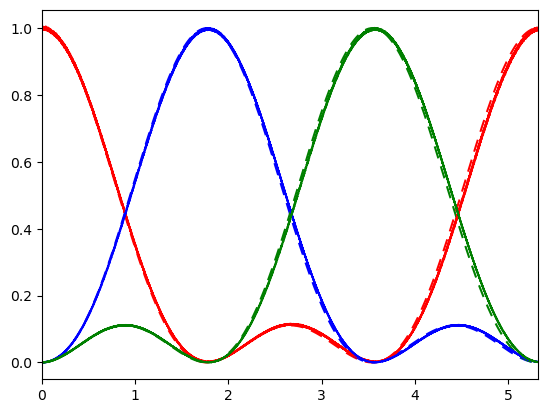

In [25]:
fig, ax = plt.subplots()
ax.plot(tlist, expect_vals_eff[:,0], label='n0',linestyle=(0, (6, 4)),color='red')
ax.plot(tlist, expect_vals_eff[:,1], label='n1',linestyle=(0, (6, 4)),color='blue')
ax.plot(tlist, expect_vals_eff[:,2], label='n2',linestyle=(0, (6, 4)),color='green')
ax.plot(tlist, expect_vals[:,0], label='n0',color='red',linestyle=(0, (20, 0)))
ax.plot(tlist, expect_vals[:,1], label='n1',color='blue',linestyle=(0, (20, 0)))
ax.plot(tlist, expect_vals[:,2], label='n2',color='green',linestyle=(0, (20, 0)))

ax.set_xlim(0,tlist[-1])
print('Ej/Ec',Ej/Ec)